In [1]:
import nbimporter
import import_ipynb


import os
import sys

def add_path_to_sys(path):
    module_path = os.path.abspath(path)
    if module_path not in sys.path:
        sys.path.append(module_path)

usePath = os.path.join(r'c:', os.sep,'Users','scrwh','Documents','PythonScripts')
add_path_to_sys(usePath)


# import ModelsListDiffFuntions
# from ModelsListDiffFuntions import *

# # List all the functions defined in the other notebook
# print(dir(ModelsListDiffFuntions))

import Functions
from Functions import *

# List all the functions defined in the other notebook
print(dir(Functions))

['FolderTree', 'IMREAD_COLOR', 'IMREAD_UNCHANGED', 'Image', 'ImageDataGenerator', 'ImageFile', 'ModelsListDiffFuntions', 'Path', 'Pool', 'PureWindowsPath', 'RMSprop', 'StringIO', 'WindowsPath', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'accuracy_score', 'add_path_to_sys', 'classification_report', 'compress_layers', 'confusion_matrix', 'copy_and_open', 'cpu_count', 'cv2', 'datetime', 'display', 'display_one', 'get_file_list', 'get_file_list_imgs', 'get_image_paths', 'get_ipython', 'glob', 'gridspec', 'hashlib', 'image', 'import_ipynb', 'io', 'jsonize', 'la', 'laplace', 'loadImages', 'lru_cache', 'nbimporter', 'np', 'os', 'pd', 'platform', 'plt', 'print_dim_tuple', 'print_layers', 'processing', 'product', 'pywt', 'random', 'random_sample', 're', 'requests', 'resize', 'rgb2gray', 'sep', 'sequential_model_to_ascii_printout', 'shutil', 'sklearn', 'sns', 'splitfolders', 'sporco', 'struct', 'subprocess', 'tf', 'time', 'torch', 'tqdm', 'train_t

In [2]:
sepp = os.path.sep

testDir = os.path.join('..','Synthetic_data','Fault_types - Copy').replace(os.path.sep, '/')
# C:\Users\scrwh\Documents\PythonScripts\Master_Thesis\Function\Synthetic_data\Fault_types - Copy
testDir

'../Synthetic_data/Fault_types - Copy'

In [3]:
data_folder = os.path.join('..','..', 'data', 'data4d').replace(os.path.sep, '/')
data_folder

'../../data/data4d'

In [4]:
DataFileList = get_file_list_imgs(testDir)
len(DataFileList)

2007

In [5]:
DataFileListCNN = get_file_list_imgs(data_folder)
len(DataFileListCNN)

29006

In [6]:
import os
import cv2
import numpy as np
import pandas as pd

def generate_image_df(imageList):
    df = pd.DataFrame()
    
    imageList = get_image_paths(imageList)
    
    paths = np.array(imageList)
    filenames = np.array([os.path.basename(path) for path in paths])
    directories = np.array([os.path.dirname(path) for path in paths])
    extensions = np.array([os.path.splitext(path)[1] for path in paths])
    split_classes = np.array(['train' if 'train' in path else 'val' if 'val' in path else 'test' if 'test' in path else None for path in paths])
    type_classes = np.array([path.split(os.path.sep)[-2] for path in paths])
    
    df['path'] = paths
    df['filename'] = filenames
    df['directory'] = directories
    df['extension'] = extensions
    df['splitClass'] = split_classes
    df['typeClass'] = type_classes
    
    image_data = [cv2.imread(path) for path in paths]
    shapes = np.array([img.shape for img in image_data])
    
    df[['height', 'width', 'channels']] = shapes
    df['aspect_ratio'] = shapes[:, 1] / shapes[:, 0]
    
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in image_data]
    blur_levels = np.array([cv2.Laplacian(img, cv2.CV_64F).var() for img in gray_images])
    df['blur_level'] = blur_levels
    df['blurry'] = blur_levels < 30
    
    dpi = plt.gcf().dpi
    resolutions = shapes[:, 0] / dpi
    df['resolution'] = resolutions
    
    color_modes = np.array([img.shape[2] for img in image_data])
    df['color_mode'] = color_modes
    
    mean_intensities = np.array([img.mean() for img in image_data])
    df['mean_intensity'] = mean_intensities
    
    sharpness = np.array([cv2.Laplacian(img, cv2.CV_64F).var() for img in gray_images])
    df['sharpness'] = sharpness
    
    threshold = 200
    proportions = np.array([np.sum(img > threshold) / img.size for img in gray_images])
    df['above_threshold_prop'] = proportions

    color_props = []
    for img in image_data:
        if img.shape[2] == 3:
            red_prop = np.sum(img[:,:,0]) / (img.size * 255)
            green_prop = np.sum(img[:,:,1]) / (img.size * 255)
            blue_prop = np.sum(img[:,:,2]) / (img.size * 255)
            color_props.append((red_prop, green_prop, blue_prop))
        else:
            color_props.append([None, None, None])  # Append a list of None for grayscale images
    df[['red_prop', 'green_prop', 'blue_prop']] = color_props

    color_stats = np.array([cv2.meanStdDev(img) for img in image_data])
    df['mean_red'] = color_stats[:, 0, 2]
    df['mean_green'] = color_stats[:, 0, 1]
    df['mean_blue'] = color_stats[:, 0, 0]
    df['std_red'] = color_stats[:, 1, 2]
    df['std_green'] = color_stats[:, 1, 1]
    df['std_blue'] = color_stats[:, 1, 0]

    
    is_gray = np.array([len(img.shape) == 2 or img.shape[2] == 1 or (img[:,:,0] == img[:,:,1]).all() for img in image_data])
    df['grayscale'] = is_gray
    
    dominant_color = []
    for img in image_data:
        if img.shape[2] == 3:
            pixels = np.float32(img.reshape(-1, 3))
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            _, labels, centers = cv2.kmeans(pixels, 1, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
            dominant_color.append(centers[0] / 255)
        else:
            dominant_color.append(None)
    df[['dominant_color_r', 'dominant_color_g', 'dominant_color_b']] = dominant_color
    
    brightness = np.array([cv2.mean(img)[0] for img in image_data])
    df['brightness'] = brightness
    
    contrast = []
    for img in gray_images:
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        hist_norm = hist.ravel() / hist.sum()
        Q = hist_norm.cumsum()
        bins = np.arange(256)
        fn_min = np.inf
        for i in range(1,256):
            p1, p2 = np.hsplit(hist_norm, [i])
            q1, q2 = Q[i], Q[255] - Q[i]
            if q1 == 0:
                q1 = 0.0000001
            if q2 == 0:
                q2 = 0.0000001
            b1, b2 = np.hsplit(bins, [i])
            m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2
            v1, v2 = np.sum(((b1 - m1)**2) * p1) / q1, np.sum(((b2 - m2)**2) * p2) / q2
            fn = v1 * q1 + v2 * q2
            if fn < fn_min:
                fn_min = fn
                thresh = i
        contrast.append(fn_min)
    df['contrast'] = contrast
    
    std_intensities = np.array([np.std(img) for img in image_data])
    df['std_intensity'] = std_intensities
    max_intensities = np.array([np.max(img) for img in image_data])
    df['max_intensity'] = max_intensities
    min_intensities = np.array([np.min(img) for img in image_data])
    df['min_intensity'] = min_intensities
    
    return df


In [7]:

start_times = datetime.now()
print(f'Started: {start_times}')

imagedf = generate_image_df(DataFileList)


end_times = datetime.now()
print(f'Ended: {end_times}')
print(f'Duration: {end_times - start_times}')

Started: 2023-09-05 07:57:07.331843
Ended: 2023-09-05 07:59:02.042403
Duration: 0:01:54.710560


<Figure size 640x480 with 0 Axes>

In [8]:
random_imagedf = imagedf.sample(n=10, random_state=42) 
random_imagedf

,path,filename,directory,extension,splitClass,typeClass,height,width,channels,aspect_ratio,...,std_blue,grayscale,dominant_color_r,dominant_color_g,dominant_color_b,brightness,contrast,std_intensity,max_intensity,min_intensity
1960,../Synthetic_data/Fault_types - Copy\rough_scr...,2C8A1612.JPG,../Synthetic_data/Fault_types - Copy\rough_scr...,.JPG,None,rough_scratch,170,256,3,1.505882,...,55.224025,False,0.438580,0.475424,0.514704,111.837983,821.190185,58.349070,255,0
526,../Synthetic_data/Fault_types - Copy\Cracks\9f...,9f444dcd-05fb-4940-991d-4203447ac1dc.jpg,../Synthetic_data/Fault_types - Copy\Cracks,.jpg,None,Cracks,235,256,3,1.089362,...,47.865315,False,0.332696,0.387405,0.417865,84.837483,531.997395,48.063752,195,7
393,../Synthetic_data/Fault_types - Copy\Cracks\45...,45e5c73a-4539-447f-9afe-5c4c968f1c2f.jpg,../Synthetic_data/Fault_types - Copy\Cracks,.jpg,None,Cracks,256,256,3,1.000000,...,4.169765,False,0.939744,0.902742,0.874967,239.634842,4.197219,7.949814,248,152
1402,../Synthetic_data/Fault_types - Copy\dirt\DJI_...,DJI_0633_08_04_png.rf.082e8b9625f67728b5622560...,../Synthetic_data/Fault_types - Copy\dirt,.jpg,None,dirt,371,586,3,1.579515,...,38.292748,False,0.301528,0.326993,0.318136,76.889695,59.956298,34.992862,121,0
433,../Synthetic_data/Fault_types - Copy\Cracks\63...,6333de831f4a0energies-15-05672-g011.png,../Synthetic_data/Fault_types - Copy\Cracks,.png,None,Cracks,1105,1335,3,1.208145,...,52.727867,False,0.828778,0.823527,0.771806,210.917594,641.135032,58.112267,255,0
576,../Synthetic_data/Fault_types - Copy\Cracks\c0...,c0a86ef8-1149-43d1-b87e-a6092e6604ca.jpg,../Synthetic_data/Fault_types - Copy\Cracks,.jpg,None,Cracks,258,256,3,0.992248,...,45.259321,False,0.340488,0.355912,0.363097,86.824491,267.577849,42.242974,162,29
1869,../Synthetic_data/Fault_types - Copy\rough_scr...,2C8A0202.JPG,../Synthetic_data/Fault_types - Copy\rough_scr...,.JPG,None,rough_scratch,170,256,3,1.505882,...,71.419647,False,0.466829,0.503399,0.475584,119.041475,620.433786,67.805926,251,7
429,../Synthetic_data/Fault_types - Copy\Cracks\61...,61a74833-a717-42cc-b919-bd24660f2ebe.jpg,../Synthetic_data/Fault_types - Copy\Cracks,.jpg,None,Cracks,223,256,3,1.147982,...,4.857228,False,0.609670,0.604867,0.595654,155.465965,8.267140,4.883117,165,42
610,../Synthetic_data/Fault_types - Copy\Cracks\cr...,cracks_15.jpg,../Synthetic_data/Fault_types - Copy\Cracks,.jpg,None,Cracks,108,162,3,1.500000,...,17.417763,True,0.971997,0.971997,0.971997,247.859282,72.840631,17.417763,255,102
530,../Synthetic_data/Fault_types - Copy\Cracks\a0...,a01d449a-d9e5-4637-bb81-23164bee8560.jpg,../Synthetic_data/Fault_types - Copy\Cracks,.jpg,None,Cracks,296,256,3,0.864865,...,53.362023,False,0.371062,0.417276,0.444885,94.620777,461.863323,51.798442,196,8


In [9]:
column_names = imagedf.columns
column_names

Index(['path', 'filename', 'directory', 'extension', 'splitClass', 'typeClass',
       'height', 'width', 'channels', 'aspect_ratio', 'blur_level', 'blurry',
       'resolution', 'color_mode', 'mean_intensity', 'sharpness',
       'above_threshold_prop', 'red_prop', 'green_prop', 'blue_prop',
       'mean_red', 'mean_green', 'mean_blue', 'std_red', 'std_green',
       'std_blue', 'grayscale', 'dominant_color_r', 'dominant_color_g',
       'dominant_color_b', 'brightness', 'contrast', 'std_intensity',
       'max_intensity', 'min_intensity'],
      dtype='object')

In [10]:

start_times = datetime.now()
print(f'Started: {start_times}')

imagedfSplit = generate_image_df(DataFileListCNN)


end_times = datetime.now()
print(f'Ended: {end_times}')
print(f'Duration: {end_times - start_times}')

Started: 2023-09-05 07:59:02.115935
Ended: 2023-09-05 08:05:35.589238
Duration: 0:06:33.473303


<Figure size 640x480 with 0 Axes>

In [11]:
imagedfSplit

,path,filename,directory,extension,splitClass,typeClass,height,width,channels,aspect_ratio,...,std_blue,grayscale,dominant_color_r,dominant_color_g,dominant_color_b,brightness,contrast,std_intensity,max_intensity,min_intensity
0,../../data/data4d\test\clean\resized_2C8A0837.JPG,resized_2C8A0837.JPG,../../data/data4d\test\clean,.JPG,test,clean,162,244,3,1.506173,...,28.350089,False,0.581893,0.608114,0.654157,148.382817,226.746391,28.810828,212,5
1,../../data/data4d\test\clean\resized_2C8A0848.JPG,resized_2C8A0848.JPG,../../data/data4d\test\clean,.JPG,test,clean,162,244,3,1.506173,...,46.611414,False,0.516574,0.537838,0.577332,131.726422,454.535051,46.590219,212,23
2,../../data/data4d\test\clean\resized_DJI_0053_...,resized_DJI_0053_07_04_png.rf.2ad528665ae939b3...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,59.148440,False,0.524229,0.555236,0.526658,133.678385,192.231952,39.349412,231,0
3,../../data/data4d\test\clean\resized_DJI_0093_...,resized_DJI_0093_02_03_png.rf.60f76c2c17e215b5...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,64.764687,False,0.415714,0.582994,0.544722,106.007052,84.056649,51.500441,255,22
4,../../data/data4d\test\clean\resized_DJI_0095_...,resized_DJI_0095_02_03_png.rf.321f12fe6155e3d4...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,66.753871,False,0.452119,0.593636,0.540683,115.290292,191.901731,55.059305,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29001,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_994.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,150,244,3,1.626667,...,78.164708,False,0.588088,0.610595,0.620094,149.962486,1380.665014,77.076096,255,0
29002,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_995.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,198,244,3,1.232323,...,122.010840,False,0.567571,0.554788,0.554679,144.730605,144.837841,120.246746,255,0
29003,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_997.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,168,244,3,1.452381,...,36.141696,False,0.303192,0.297851,0.293986,77.313939,52.364526,35.480469,138,0
29004,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_998.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,175,244,3,1.394286,...,90.656531,False,0.429977,0.433404,0.429754,109.644215,1303.957704,90.247553,236,0


In [12]:
column_names = imagedfSplit.columns
column_names

Index(['path', 'filename', 'directory', 'extension', 'splitClass', 'typeClass',
       'height', 'width', 'channels', 'aspect_ratio', 'blur_level', 'blurry',
       'resolution', 'color_mode', 'mean_intensity', 'sharpness',
       'above_threshold_prop', 'red_prop', 'green_prop', 'blue_prop',
       'mean_red', 'mean_green', 'mean_blue', 'std_red', 'std_green',
       'std_blue', 'grayscale', 'dominant_color_r', 'dominant_color_g',
       'dominant_color_b', 'brightness', 'contrast', 'std_intensity',
       'max_intensity', 'min_intensity'],
      dtype='object')

In [13]:
imagedf.info

<bound method DataFrame.info of                                                    path  \
0     ../Synthetic_data/Fault_types - Copy\Bird stri...   
1     ../Synthetic_data/Fault_types - Copy\clean\2C8...   
2     ../Synthetic_data/Fault_types - Copy\clean\2C8...   
3     ../Synthetic_data/Fault_types - Copy\clean\2C8...   
4     ../Synthetic_data/Fault_types - Copy\clean\2C8...   
...                                                 ...   
2002  ../Synthetic_data/Fault_types - Copy\Rust\DJI_...   
2003  ../Synthetic_data/Fault_types - Copy\Rust\DJI_...   
2004  ../Synthetic_data/Fault_types - Copy\Rust\DJI_...   
2005  ../Synthetic_data/Fault_types - Copy\Rust\DJI_...   
2006  ../Synthetic_data/Fault_types - Copy\Rust\DJI_...   

                                               filename  \
0                              Bird strikes_msma_65.jpg   
1                                          2C8A0837.JPG   
2                                          2C8A0838.JPG   
3                      

In [105]:
imagedf.describe().T

,count,mean,std,min,25%,50%,75%,max
height,2007.0,452.661684,606.447407,56.000000,170.000000,246.000000,371.000000,3261.000000
width,2007.0,652.897359,1005.474220,91.000000,256.000000,256.000000,586.000000,5280.000000
channels,2007.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
aspect_ratio,2007.0,1.421684,0.408523,0.286674,1.166428,1.505882,1.579515,3.531746
blur_level,2007.0,413.749091,973.381841,0.313873,8.185821,113.279622,445.610793,20388.115001
resolution,2007.0,4.526617,6.064474,0.560000,1.700000,2.460000,3.710000,32.610000
color_mode,2007.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean_intensity,2007.0,134.608817,35.645089,30.735585,111.391351,133.698357,154.369193,247.859282
sharpness,2007.0,413.749091,973.381841,0.313873,8.185821,113.279622,445.610793,20388.115001
above_threshold_prop,2007.0,0.142673,0.211908,0.000000,0.000000,0.060608,0.189020,0.997020


In [70]:
df = sqldf("SELECT * FROM imagedfSplit")
df

,path,filename,directory,extension,splitClass,typeClass,height,width,channels,aspect_ratio,...,std_blue,grayscale,dominant_color_r,dominant_color_g,dominant_color_b,brightness,contrast,std_intensity,max_intensity,min_intensity
0,../../data/data4d\test\clean\resized_2C8A0837.JPG,resized_2C8A0837.JPG,../../data/data4d\test\clean,.JPG,test,clean,162,244,3,1.506173,...,28.350089,0,0.581893,0.608114,0.654157,148.382817,226.746391,28.810828,212,5
1,../../data/data4d\test\clean\resized_2C8A0848.JPG,resized_2C8A0848.JPG,../../data/data4d\test\clean,.JPG,test,clean,162,244,3,1.506173,...,46.611414,0,0.516574,0.537838,0.577332,131.726422,454.535051,46.590219,212,23
2,../../data/data4d\test\clean\resized_DJI_0053_...,resized_DJI_0053_07_04_png.rf.2ad528665ae939b3...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,59.148440,0,0.524229,0.555236,0.526658,133.678385,192.231952,39.349412,231,0
3,../../data/data4d\test\clean\resized_DJI_0093_...,resized_DJI_0093_02_03_png.rf.60f76c2c17e215b5...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,64.764687,0,0.415714,0.582994,0.544722,106.007052,84.056649,51.500441,255,22
4,../../data/data4d\test\clean\resized_DJI_0095_...,resized_DJI_0095_02_03_png.rf.321f12fe6155e3d4...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,66.753871,0,0.452119,0.593636,0.540683,115.290292,191.901731,55.059305,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29001,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_994.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,150,244,3,1.626667,...,78.164708,0,0.588088,0.610595,0.620094,149.962486,1380.665014,77.076096,255,0
29002,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_995.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,198,244,3,1.232323,...,122.010840,0,0.567571,0.554788,0.554679,144.730605,144.837841,120.246746,255,0
29003,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_997.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,168,244,3,1.452381,...,36.141696,0,0.303192,0.297851,0.293986,77.313939,52.364526,35.480469,138,0
29004,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_998.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,175,244,3,1.394286,...,90.656531,0,0.429977,0.433404,0.429754,109.644215,1303.957704,90.247553,236,0


In [72]:
# Summary statistics table:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,29006.0,202.437461,47.494889,69.000000,175.000000,196.000000,217.000000,851.000000
width,29006.0,244.000000,0.000000,244.000000,244.000000,244.000000,244.000000,244.000000
channels,29006.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
aspect_ratio,29006.0,1.262887,0.274480,0.286722,1.124424,1.244898,1.394286,3.536232
blur_level,29006.0,741.816439,678.266802,0.379266,295.315949,569.750459,968.055157,9527.839567
blurry,29006.0,0.014583,0.119879,0.000000,0.000000,0.000000,0.000000,1.000000
resolution,29006.0,2.024375,0.474949,0.690000,1.750000,1.960000,2.170000,8.510000
color_mode,29006.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean_intensity,29006.0,96.011877,40.787119,14.282575,64.983828,89.746330,121.639231,251.292641
sharpness,29006.0,741.816439,678.266802,0.379266,295.315949,569.750459,968.055157,9527.839567


C:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


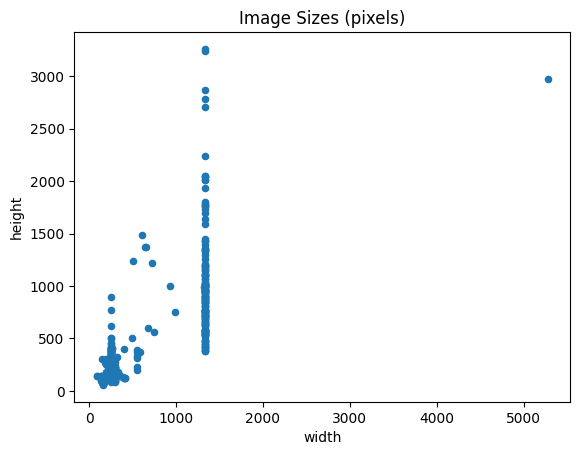

In [15]:
sizes = imagedf.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.plot.scatter(x='width', y='height');
plt.title('Image Sizes (pixels)')
# plt.title('Image Sizes (pixels) | {}'.format(Class)
plt.savefig('Size_distribution_of_image_data.png')

C:\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


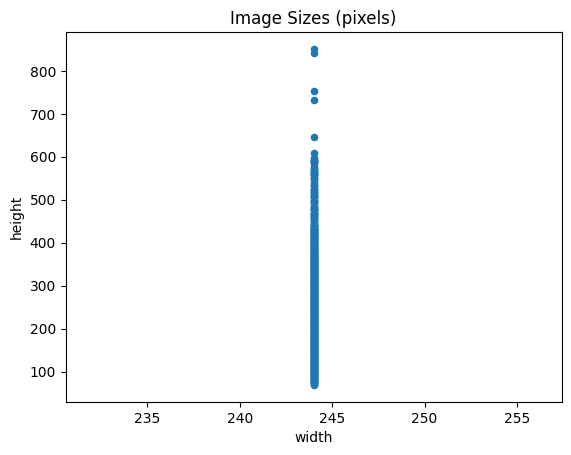

In [16]:
sizes = imagedfSplit.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.plot.scatter(x='width', y='height');
plt.title('Image Sizes (pixels)')
# plt.title('Image Sizes (pixels) | {}'.format(Class)
plt.savefig('Size_distribution_of_image_data.png')

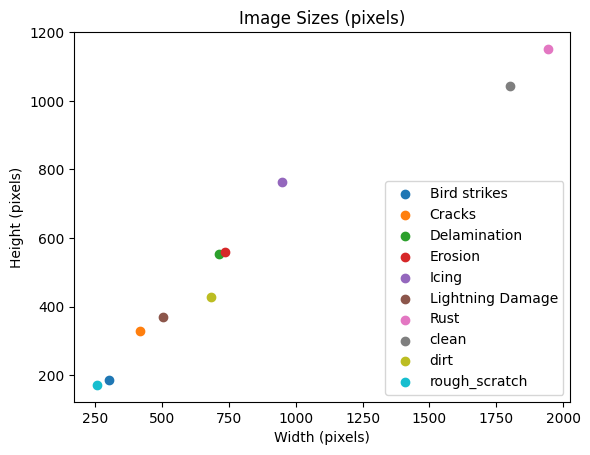

In [17]:
import matplotlib.pyplot as plt

# Group the data by class
class_sizes = imagedf.groupby('typeClass')[['height', 'width']].mean()
# class_sizes = imagedfSplit.groupby('typeClass')[['height', 'width']].size().reset_index().rename(columns={0:'count'})

# Create a scatter plot for each class
for c in class_sizes.index:
    plt.scatter(class_sizes.loc[c, 'width'], class_sizes.loc[c, 'height'], label=c)

# Add labels and title to the plot
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Sizes (pixels)')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


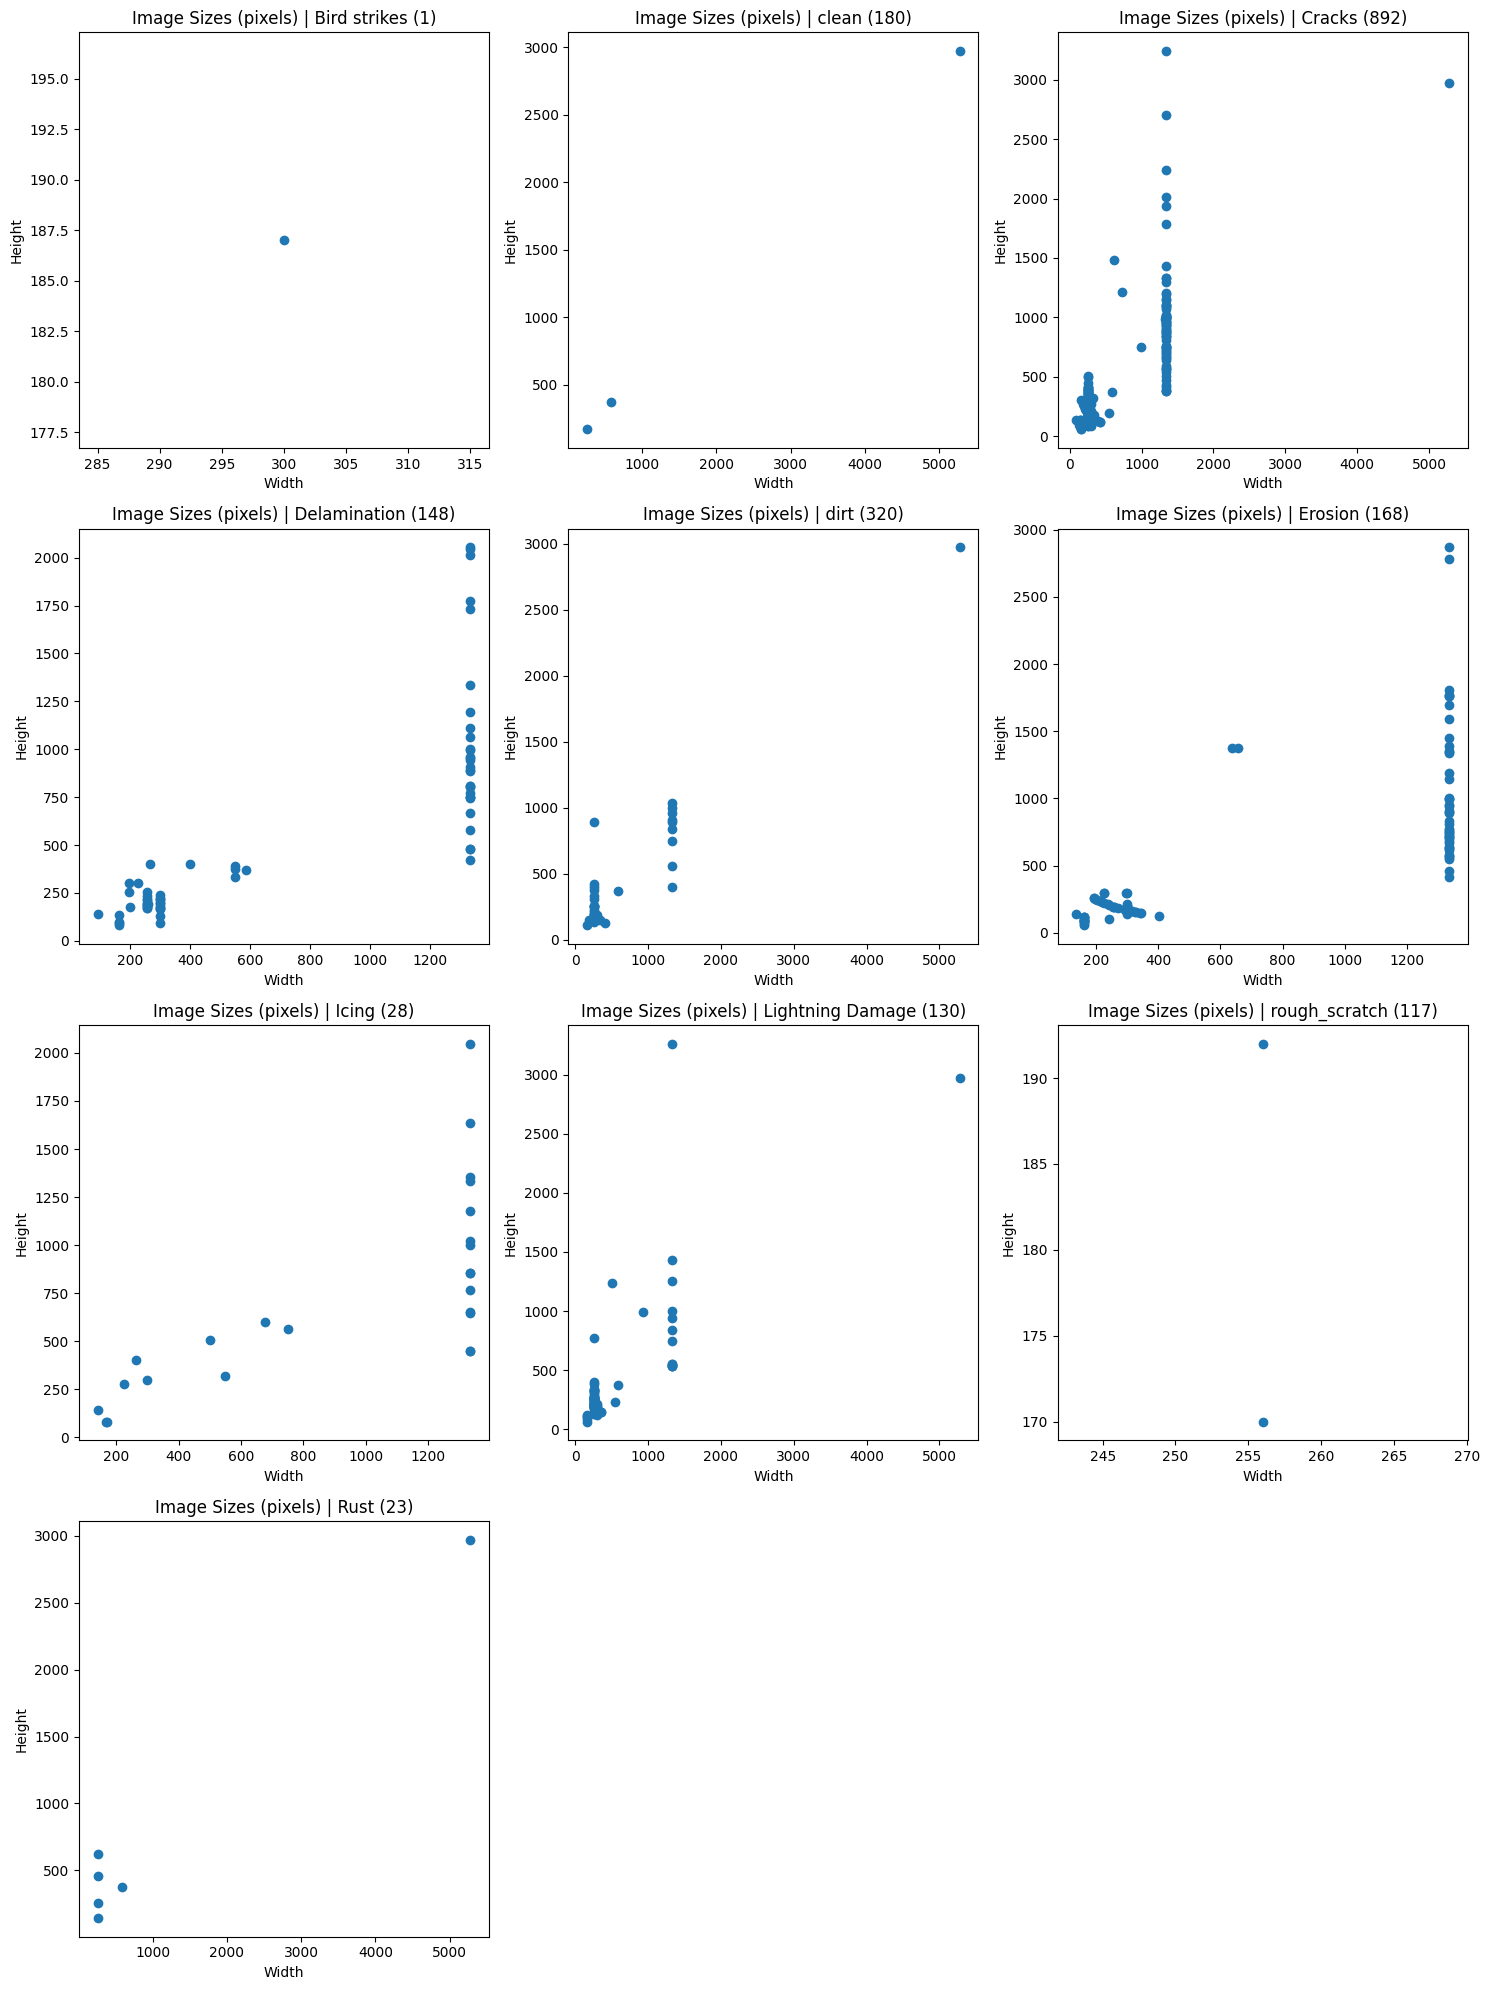

In [18]:
import matplotlib.pyplot as plt

# Get unique classes
classes = imagedf['typeClass'].unique()

# Calculate number of rows needed for subplots
nrows = (len(classes) // 3) + (len(classes) % 3 > 0)

# Create figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5*nrows))

# Iterate over each class and create a scatter plot
for i, Class in enumerate(classes):
    row, col = i // 3, i % 3
    class_df = imagedf[imagedf['typeClass'] == Class]
    sizes = class_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    axs[row, col].scatter(x=sizes['width'], y=sizes['height'])
    axs[row, col].set_title('Image Sizes (pixels) | {} ({})'.format(Class, len(class_df)))
    axs[row, col].set_xlabel('Width')
    axs[row, col].set_ylabel('Height')

# Remove any unused subplots
for i in range(len(classes), nrows*3):
    row, col = i // 3, i % 3
    fig.delaxes(axs[row, col])

plt.tight_layout()
# plt.savefig('Size_distribution_of_image_data.png')
plt.savefig('Size_distribution_of_image_data_by_Class.png', bbox_inches='tight')
plt.show()


In [45]:
import pandas as pd
from pandasql import sqldf

In [21]:
dff = sqldf("SELECT * FROM imagedfSplit")
dff

,path,filename,directory,extension,splitClass,typeClass,height,width,channels,aspect_ratio,...,std_blue,grayscale,dominant_color_r,dominant_color_g,dominant_color_b,brightness,contrast,std_intensity,max_intensity,min_intensity
0,../../data/data4d\test\clean\resized_2C8A0837.JPG,resized_2C8A0837.JPG,../../data/data4d\test\clean,.JPG,test,clean,162,244,3,1.506173,...,28.350089,0,0.581893,0.608114,0.654157,148.382817,226.746391,28.810828,212,5
1,../../data/data4d\test\clean\resized_2C8A0848.JPG,resized_2C8A0848.JPG,../../data/data4d\test\clean,.JPG,test,clean,162,244,3,1.506173,...,46.611414,0,0.516574,0.537838,0.577332,131.726422,454.535051,46.590219,212,23
2,../../data/data4d\test\clean\resized_DJI_0053_...,resized_DJI_0053_07_04_png.rf.2ad528665ae939b3...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,59.148440,0,0.524229,0.555236,0.526658,133.678385,192.231952,39.349412,231,0
3,../../data/data4d\test\clean\resized_DJI_0093_...,resized_DJI_0093_02_03_png.rf.60f76c2c17e215b5...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,64.764687,0,0.415714,0.582994,0.544722,106.007052,84.056649,51.500441,255,22
4,../../data/data4d\test\clean\resized_DJI_0095_...,resized_DJI_0095_02_03_png.rf.321f12fe6155e3d4...,../../data/data4d\test\clean,.jpg,test,clean,154,244,3,1.584416,...,66.753871,0,0.452119,0.593636,0.540683,115.290292,191.901731,55.059305,255,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29001,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_994.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,150,244,3,1.626667,...,78.164708,0,0.588088,0.610595,0.620094,149.962486,1380.665014,77.076096,255,0
29002,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_995.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,198,244,3,1.232323,...,122.010840,0,0.567571,0.554788,0.554679,144.730605,144.837841,120.246746,255,0
29003,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_997.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,168,244,3,1.452381,...,36.141696,0,0.303192,0.297851,0.293986,77.313939,52.364526,35.480469,138,0
29004,../../data/data4d\val\Rust\resized_synthetic_9...,resized_synthetic_998.jpg,../../data/data4d\val\Rust,.jpg,val,Rust,175,244,3,1.394286,...,90.656531,0,0.429977,0.433404,0.429754,109.644215,1303.957704,90.247553,236,0


In [24]:
countSlit = sqldf("SELECT splitClass, count(*) total FROM imagedfSplit group by splitClass")
countSlit.to_csv(os.path.join('results','SplitDistribution.csv'), index=False)
countSlit

,splitClass,total
0,test,2907
1,train,20301
2,val,5798


In [67]:
a = """
SELECT splitClass, 
  COUNT(*) AS total,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) total FROM imagedfSplit),1) AS "%"
FROM imagedfSplit 
GROUP BY splitClass
"""

countSlit = sqldf(a)

countSlit.to_csv(os.path.join('results','SplitDistribution.csv'), index=False)

countSlit

,splitClass,total,%
0,test,2907,10.0
1,train,20301,70.0
2,val,5798,20.0


In [68]:
a = """ select case when r = 1 then split || ' : ' || CAST(split_Count AS TEXT) else '' end Split , class, total from
(select a.splitClass_a as split, a. total as split_Count, b.class, b.total, row_number() over(partition by splitClass_a order by splitClass_a,class) r  
            from 
            (SELECT splitClass as splitClass_a, count(*) total FROM imagedfSplit group by splitClass) a
            left join 
            (SELECT splitClass,typeClass as class, count(*) total FROM imagedfSplit group by splitClass,typeClass) b
            on a.splitClass_a = b.splitClass ) a
            
            """

countSlit = sqldf(a)
countSlit

,Split,class,total
0,test : 2907,Cracks,390
1,,Delamination,316
2,,Erosion,318
3,,Icing,304
4,,Lightning Damage,313
5,,Rust,303
6,,clean,318
7,,dirt,332
8,,rough_scratch,313
9,train : 20301,Cracks,2724


In [69]:
a = """ select *, (train+val+test) total, ROUND((train+val+test) * 100.0 / (SELECT COUNT(*) FROM imagedfSplit), 1) AS "%"
from
(select a.*,b.val,c.test 
from
(SELECT typeClass as class, count(*) train FROM imagedfSplit where splitClass = 'train' group by typeClass ) a
left join 
(SELECT typeClass, count(*) val FROM imagedfSplit where splitClass = 'val' group by typeClass ) b
on a.class = b.typeClass
left join 
(SELECT typeClass, count(*) test FROM imagedfSplit where splitClass = 'test' group by typeClass ) c
on a.class = c.typeClass) a
group by class
            
            """

countClass = sqldf(a)
countClass.to_csv(os.path.join('results','classDistribution.csv'), index=False)
countClass

,class,train,val,test,total,%
0,Cracks,2724,778,390,3892,13.4
1,Delamination,2203,629,316,3148,10.9
2,Erosion,2217,633,318,3168,10.9
3,Icing,2119,605,304,3028,10.4
4,Lightning Damage,2191,626,313,3130,10.8
5,Rust,2116,604,303,3023,10.4
6,clean,2226,636,318,3180,11.0
7,dirt,2324,664,332,3320,11.4
8,rough_scratch,2181,623,313,3117,10.7


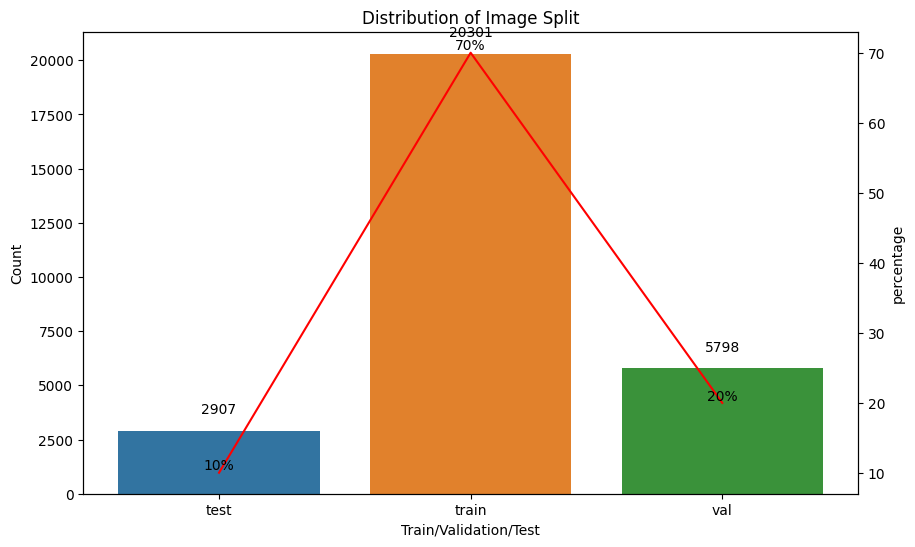

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by the "train_val_test" column and count the number of occurrences
grouped_data = imagedfSplit.groupby("splitClass")["path"].count().reset_index()
grouped_data.columns = ["splitClass", "count"]

# Calculate the percentage of each "train_val_test" group
grouped_data["percentage"] = grouped_data["count"] / grouped_data["count"].sum() * 100

# Create the barplot using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=grouped_data, x="splitClass", y="count", ax=ax)

# Add the count values to the top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type="edge", padding=10)

# Add the percentage values to the top of each bar (on the right side)
ax2 = ax.twinx()
sns.lineplot(data=grouped_data, x="splitClass", y="percentage", ax=ax2, color="red")
for index, row in grouped_data.iterrows():
    ax2.text(row.name, row.percentage, str(round(row.percentage)) + "%", ha="center", va="bottom")

# Set the axis labels and title
ax.set_xlabel("Train/Validation/Test")
ax.set_ylabel("Count")
ax.set_title("Distribution of Image Split")
plt.show()


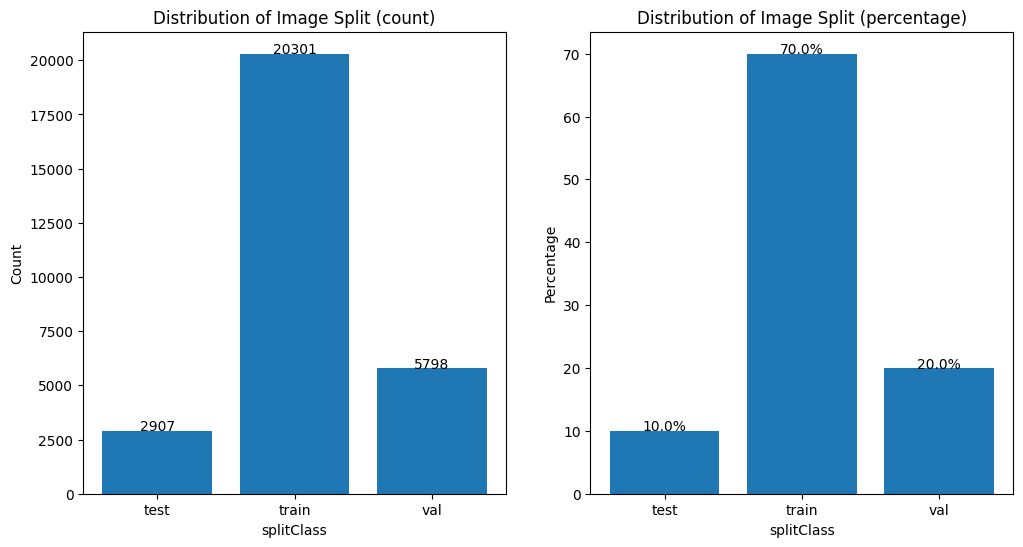

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# count of train_val_test
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

train_val_test_count = imagedfSplit.groupby('splitClass')['path'].count()

# ax1.bar(train_val_test_count.index, train_val_test_count.values, color='blue')
ax1.bar(train_val_test_count.index, train_val_test_count.values)
ax1.set_xlabel('splitClass')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Image Split (count)')

for i, v in enumerate(train_val_test_count.values):
    ax1.text(i, v, str(v), ha='center')

# percentage distribution of train_val_test
train_val_test_percentage = train_val_test_count / train_val_test_count.sum() * 100

# ax2.bar(train_val_test_percentage.index, train_val_test_percentage.values, color='grey')
ax2.bar(train_val_test_percentage.index, train_val_test_percentage.values)
ax2.set_xlabel('splitClass')
ax2.set_ylabel('Percentage')
ax2.set_title('Distribution of Image Split (percentage)')

for i, v in enumerate(train_val_test_percentage.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center')

plt.show()


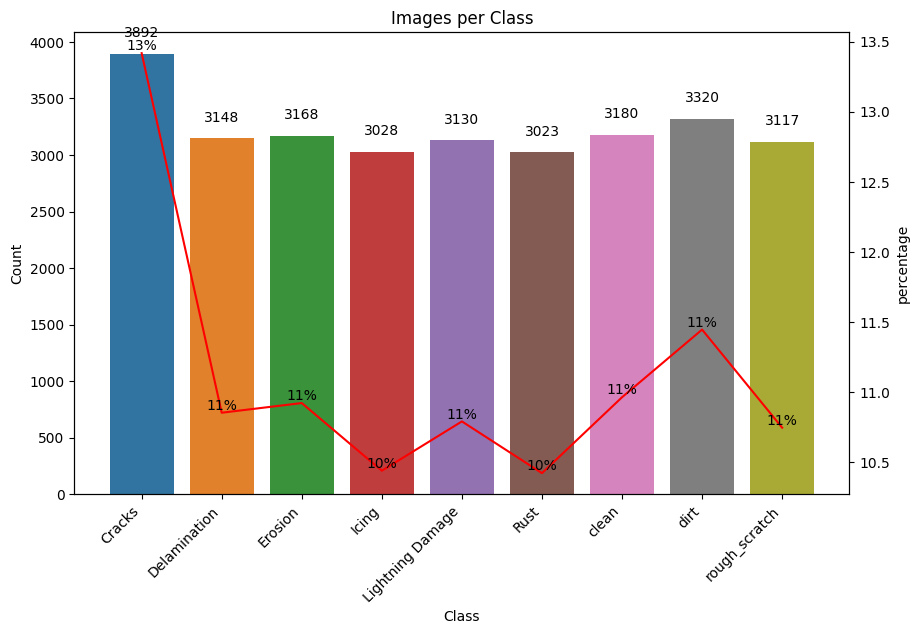

In [89]:
# Group the data by the "train_val_test" column and count the number of occurrences
grouped_data = imagedfSplit.groupby("typeClass")["path"].count().reset_index()
grouped_data.columns = ["typeClass", "count"]

# Calculate the percentage of each "train_val_test" group
grouped_data["percentage"] = grouped_data["count"] / grouped_data["count"].sum() * 100

# Create the barplot using seaborn
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=grouped_data, x="typeClass", y="count", ax=ax)

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Add the count values to the top of each bar
for i in ax.containers:
    ax.bar_label(i, label_type="edge", padding=10)

# Add the percentage values to the top of each bar (on the right side)
ax2 = ax.twinx()

sns.lineplot(data=grouped_data, x="typeClass", y="percentage", ax=ax2, color="red")

for index, row in grouped_data.iterrows():
    ax2.text(row.name, row.percentage, str(round(row.percentage)) + "%", ha="center", va="bottom")

# Set the axis labels and title
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("Images per Class")

plt.show()

C:\Users\scrwh\AppData\Local\Temp\ipykernel_34896\2067762651.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(train_val_test_count.index, rotation=45)
C:\Users\scrwh\AppData\Local\Temp\ipykernel_34896\2067762651.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(train_val_test_percentage.index, rotation=45)


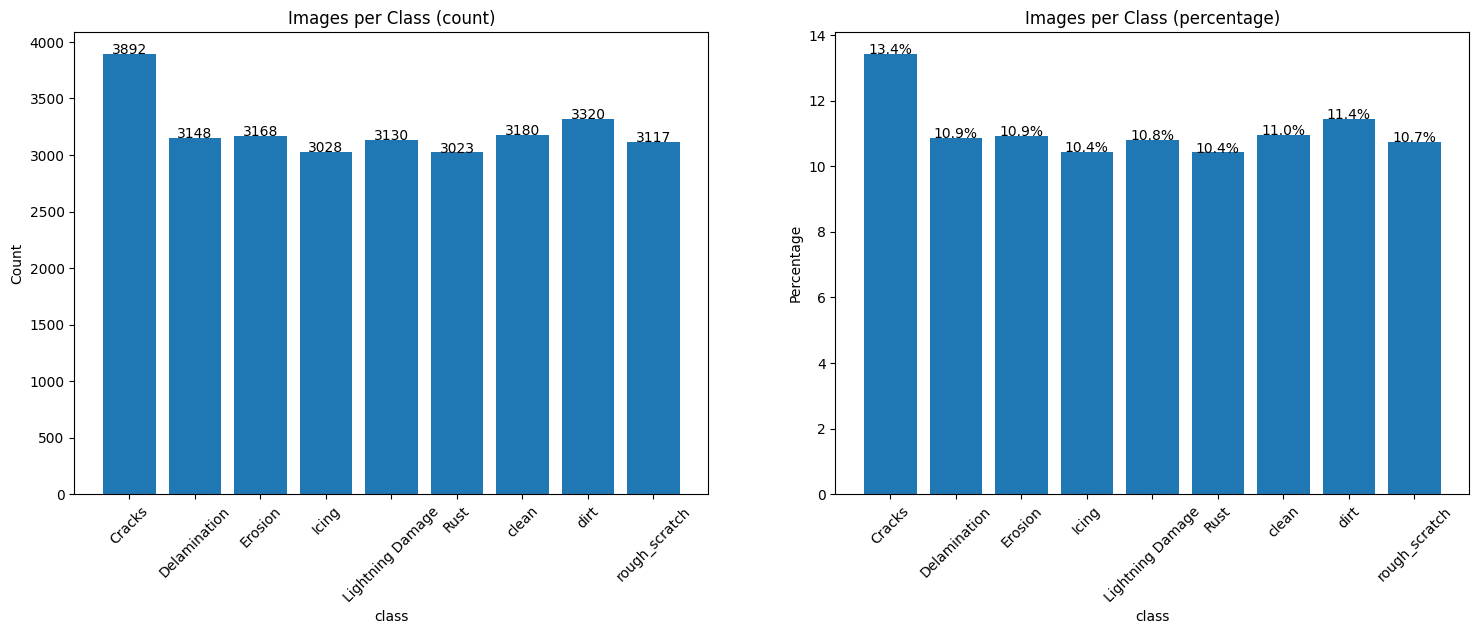

In [86]:
import matplotlib.pyplot as plt
import numpy as np


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))


train_val_test_count = imagedfSplit.groupby('typeClass')['path'].count()

ax1.bar(train_val_test_count.index, train_val_test_count.values)
ax1.set_xlabel('class')
ax1.set_ylabel('Count')
ax1.set_title('Images per Class (count)')
ax1.set_xticklabels(train_val_test_count.index, rotation=45)

for i, v in enumerate(train_val_test_count.values):
    ax1.text(i, v, str(v), ha='center')

# percentage distribution of train_val_test
train_val_test_percentage = train_val_test_count / train_val_test_count.sum() * 100

ax2.bar(train_val_test_percentage.index, train_val_test_percentage.values)
ax2.set_xlabel('class')
ax2.set_ylabel('Percentage')
ax2.set_title('Images per Class (percentage)')
ax2.set_xticklabels(train_val_test_percentage.index, rotation=45) 

for i, v in enumerate(train_val_test_percentage.values):
    ax2.text(i, v, f'{v:.1f}%', ha='center')

plt.show()

Text(0.5, 1.0, 'Aspect Ratio vs Resolution')

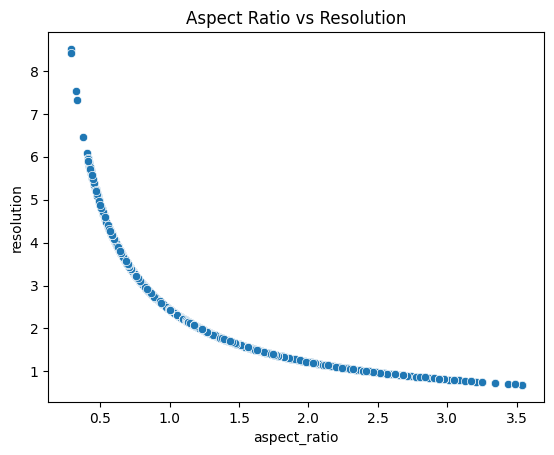

In [74]:
# Scatterplot of aspect ratio vs resolution:

import seaborn as sns
sns.scatterplot(data=df, x='aspect_ratio', y='resolution')
plt.title('Aspect Ratio vs Resolution')

Text(0.5, 1.0, 'Sharpness vs Blurry')

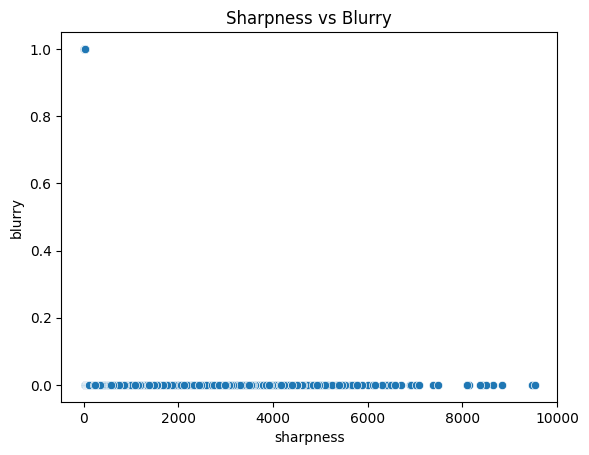

In [104]:
# plt.scatter(df['sharpness'], df['blurry'])
# plt.xlabel('Sharpness')
# plt.ylabel('Blurry (True/False)')
sns.scatterplot(data=df, x='sharpness', y='blurry')
plt.title('Sharpness vs Blurry')

In [75]:
# Table of average blurriness per class:

blurry_pct = df.groupby('typeClass')['blurry'].mean() * 100
blurry_pct = blurry_pct.rename('Percent Blurry').reset_index()
blurry_pct

,typeClass,Percent Blurry
0,Cracks,7.528263
1,Delamination,0.317662
2,Erosion,0.063131
3,Icing,1.254954
4,Lightning Damage,1.341853
5,Rust,0.132319
6,clean,0.188679
7,dirt,0.813253
8,rough_scratch,0.032082


Text(0.5, 1.0, 'Distribution of Color Channels')

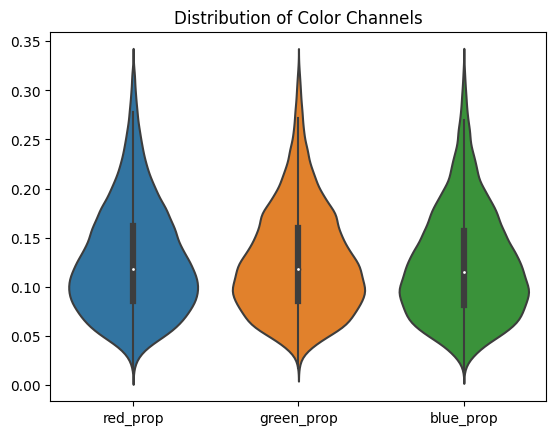

In [85]:
# Violin plots of color channels:

sns.violinplot(data=df[['red_prop','green_prop','blue_prop']])
plt.title('Distribution of Color Channels')

Text(0.5, 1.0, 'Correlation Heatmap')

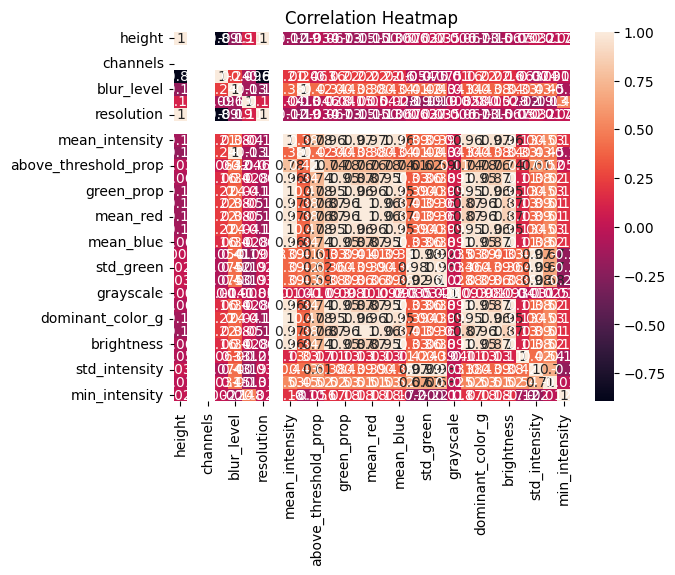

In [92]:
# Heatmap of correlations:

sns.heatmap(df.corr(), annot=True) 
plt.title('Correlation Heatmap')

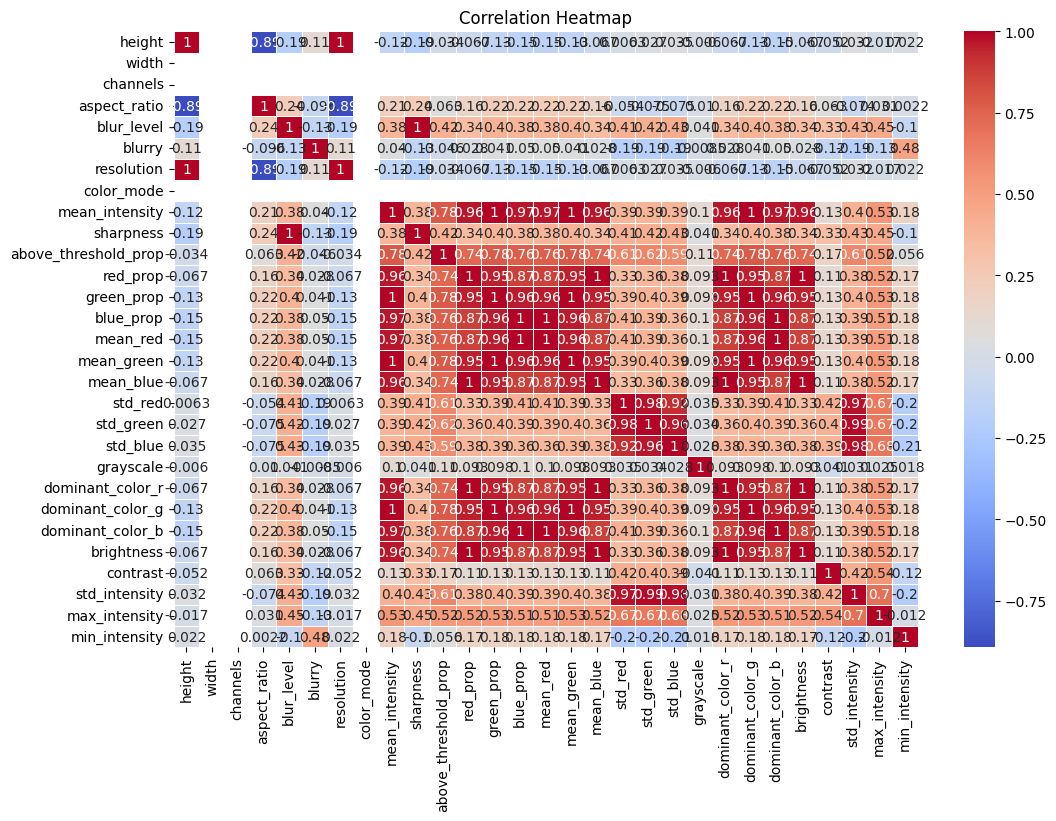

In [83]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [95]:
numeric_cols = ['height', 'width', 'blur_level', 'resolution', 'mean_intensity', 'sharpness', 'contrast', 'brightness']

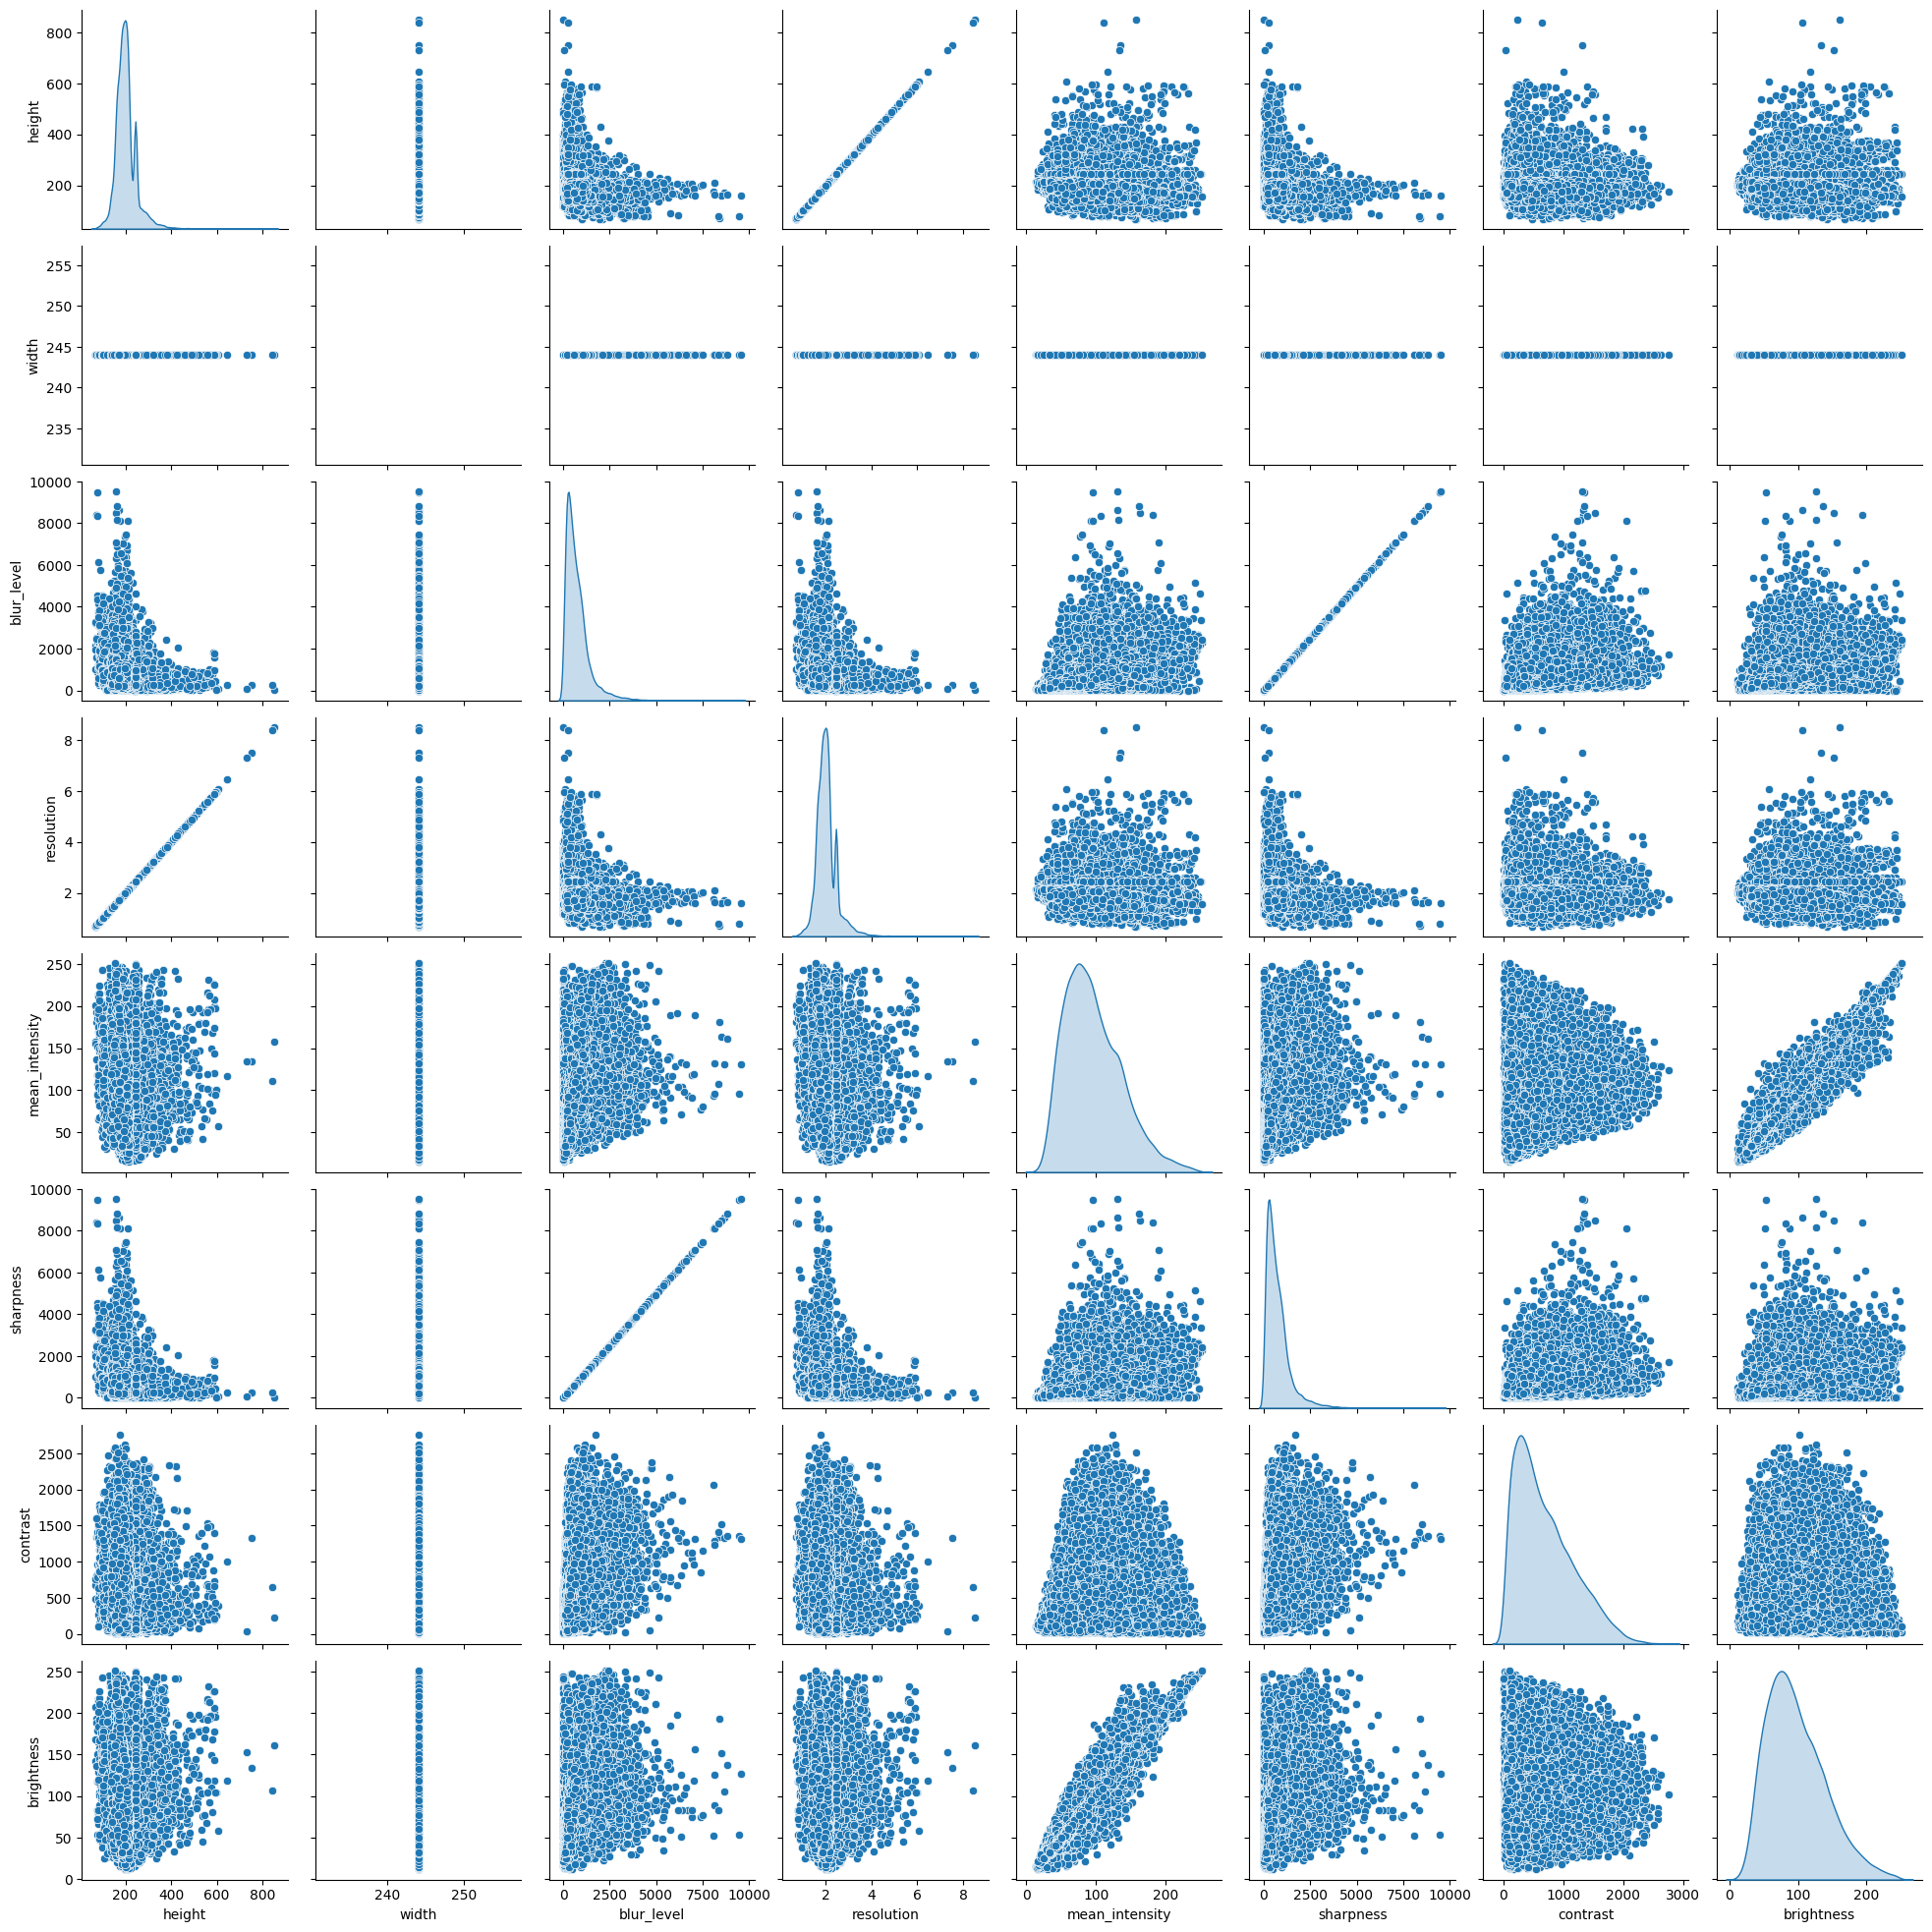

In [96]:


sns.pairplot(df[numeric_cols], diag_kind='kde')
plt.show()



```python
for col1 in numeric_cols:
    for col2 in numeric_cols:
        if col1 != col2:
            plt.figure(figsize=(8, 4))
            sns.scatterplot(x=col1, y=col2, data=df)
            plt.title(f'Scatter Plot of {col1} vs. {col2}')
            plt.show()
```

```python
numeric_cols = ['height', 'width', 'aspect_ratio', 'blur_level', 'resolution', 'mean_intensity', 'sharpness', 'above_threshold_prop', 'red_prop', 'green_prop', 'blue_prop', 'mean_red', 'mean_green', 'mean_blue', 'std_red', 'std_green', 'std_blue', 'brightness', 'contrast', 'std_intensity', 'max_intensity', 'min_intensity']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=col, data=df)
    plt.title(f'Box Plot of {col}')
    plt.show()
```

```python

# Function to generate summary statistics table
def summary_statistics(df):
    return df.describe().T

# Function to generate histogram plots
def histogram_plots(df, columns):
    for column in columns:
        plt.figure(figsize=(8, 6))
        df[column].plot(kind='hist', bins=20, title=f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

# Function to generate count of categorical values
def count_categorical_values(df, columns):
    for column in columns:
        value_counts = df[column].value_counts()
        print(f'Counts for {column}:\n{value_counts}\n')

# Function to generate box plots
def box_plots(df, numeric_columns):
    for column in numeric_columns:
        plt.figure(figsize=(8, 6))
        df.boxplot(column=column)
        plt.title(f'Box Plot of {column}')
        plt.ylabel(column)
        plt.show()

# Function to generate correlation matrix
def correlation_matrix(df):
    correlation_matrix = df.corr()
    return correlation_matrix

# Function to generate scatter plots
def scatter_plots(df, numeric_columns):
    sns.pairplot(df[numeric_columns], diag_kind='kde')
    plt.show()

# Create a list of EDAs and their corresponding functions
edas = [
    {"name": "Summary Statistics", "function": summary_statistics},
    {"name": "Histogram Plots", "function": histogram_plots, "args": [list(df.select_dtypes(include=['number']).columns)]},
    {"name": "Count of Categorical Values", "function": count_categorical_values, "args": [list(df.select_dtypes(include=['object']).columns)]},
    {"name": "Box Plots", "function": box_plots, "args": [list(df.select_dtypes(include=['number']).columns)]},
    {"name": "Correlation Matrix", "function": correlation_matrix},
    {"name": "Scatter Plots", "function": scatter_plots, "args": [list(df.select_dtypes(include=['number']).columns)]}
]


# Execute the EDAs and generate tables and visualizations
for eda in edas:
    print(f"--- {eda['name']} ---")
    if "args" in eda:
        eda["function"](df, *eda["args"])
    else:
        result = eda["function"](df)
        if isinstance(result, pd.DataFrame):
            print(result)
```